# The Wilcoxon rank-sums test
### ... or the Mann-Whitney U test

*Gries, chapter 4, pp. 227-233*


#### Recap and rationale

In the previous sprints we've introduced the concept of a normal distribution, a very common model (in the shape of a bell curve), to capture the symmetric spread of a variable around a mean. We've talked about probability density functions that allow us to quantify the notorious $p$-values, describing what the probability is that a particular value was sampled from such a distribution. You understand that the further such a variable is removed from the mean of the distribution (in either direction) and the more it moves into the direction of one of the two tails of the density curve, the more unlikely it is that it was associated with the distribution.

We've also promised that this would be useful to understand how a statistical test works. However, the only thing that you know about these tests so far is that they spit out some kind of mysterious test statistic. We've asked you to trust us for the time being and not wonder how this test statistic is produced. In general, you can just assume that this number tells you something about the magnitude of the test result, e.g. it somehow captures the difference, for instance, in the length of sentences between two speakers. 

We have first covered how we can assess or evaluate that test statistic. As mentioned, conventional statistical tests are defined in very clever ways. Essentially, they have been set up in such a way that *if the null hypothesis holds*, we know **what the distribution of the test statistic should look like**. Often, this distribution is a normal and that's exactly why we had to cover the normal distribution first: this makes it easy to derive the $p$-value of the test statistic, since we can calculate whether the test statistic exceeds a certain critical threshold in that respect. If the test statistic takes a very extreme value (in the light of the distribution that we expected), we can argue that the null nypothesis should be rejected.

In this notebook, we'll talk you through a very intuitive test and present you with a very accessible example of how such a test statistic can be calculated and why we could anticipate what its behaviour should be, if the null hypothesis were true. The nice thing about this test is that it's pretty straightforward to understand but it is not some kind of simplified, naive, dummy example: it's in fact a real-world procedure that is used in a common test: this test is known as the Wilcoxon rank-sums test (or the Mann-Whitney $U$ test).

#### Case study: pitch across men with different orientations (AKA queer phonology)

In the handbook you might have seen that Gries often refers to a famous case study regarding the pitch of the voice of **two groups of men with different sexual orientation**s. The existing literature has argued that the *average* pitch between gay and straight men does not differ statistically, but there is evidence that the variance in pitch does differ significantly between the two groups, meaning that homosexual men show more variation in pitch across their speech signal than heterosexual man. We've found a dataset for Spanish speakers that allows us to look into this fascinating topic from **sociophonetics**. You can load it as follows:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm
import math

In [4]:
df = pd.read_csv("../../datasets/queer/queer_speech.csv")
df

,ID,sex,age,orientation,Testosterone,time,meanf0,f0sd,jitter,HNR,country_birth,mother_country,gp_father_maternal_country,gp_mother_maternal_country,father_country,gp_father_paternal_country,gp_mother_paternal_country,relationship,education,monthly_income
0,AA_110118_11,M,23,homosexual,178.866,41.41,103.50,13.48,2.63,9.53,france,france,france,france,france,france,france,no,Bac+4,1
1,AAV_06122017_4,M,21,heterosexual,108.809,44.09,108.76,13.24,2.01,10.21,france,france,france,france,france,france,france,yes,Bac+2,1
2,AAV_110118_10,M,24,heterosexual,100.154,32.81,91.42,13.99,2.38,9.33,france,france,france,france,france,france,france,yes,Bac+5,1
3,AAV_12122017_5,M,22,heterosexual,137.178,46.73,109.77,20.68,3.06,9.39,france,france,france,france,france,france,france,yes,Bac+3,1
4,AAV_131217_6,M,22,homosexual,98.721,39.57,117.36,13.68,1.66,12.62,france,france,france,france,france,france,france,no,Bac+3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,VAA_200118_3,M,30,heterosexual,121.875,32.26,99.31,14.19,3.60,8.04,france,france,france,france,france,europe,europe,yes,Bac+5,7
156,VAA_200118_5,M,31,heterosexual,112.249,40.77,123.59,27.43,2.57,10.95,france,france,france,france,france,france,france,yes,Bac+5,6
157,VAA_230118_1,M,24,heterosexual,136.869,39.02,109.06,24.16,2.62,10.36,france,france,france,france,france,france,france,yes,Bac+5,3
158,VAA_230118_2,M,25,heterosexual,116.582,34.56,85.70,19.40,3.29,8.78,france,france,france,france,france,france,france,yes,Bac+5,5


As you can, these scholars collected a whole bunch of interesting variables for each speaker. The dataset also includes (heterosexual) women, but we'll exclude these for the time being, and focus on the "M" sex:

In [5]:
df = df[df["sex"] == "M"]
df

,ID,sex,age,orientation,Testosterone,time,meanf0,f0sd,jitter,HNR,country_birth,mother_country,gp_father_maternal_country,gp_mother_maternal_country,father_country,gp_father_paternal_country,gp_mother_paternal_country,relationship,education,monthly_income
0,AA_110118_11,M,23,homosexual,178.866,41.41,103.50,13.48,2.63,9.53,france,france,france,france,france,france,france,no,Bac+4,1
1,AAV_06122017_4,M,21,heterosexual,108.809,44.09,108.76,13.24,2.01,10.21,france,france,france,france,france,france,france,yes,Bac+2,1
2,AAV_110118_10,M,24,heterosexual,100.154,32.81,91.42,13.99,2.38,9.33,france,france,france,france,france,france,france,yes,Bac+5,1
3,AAV_12122017_5,M,22,heterosexual,137.178,46.73,109.77,20.68,3.06,9.39,france,france,france,france,france,france,france,yes,Bac+3,1
4,AAV_131217_6,M,22,homosexual,98.721,39.57,117.36,13.68,1.66,12.62,france,france,france,france,france,france,france,no,Bac+3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,VAA_200118_3,M,30,heterosexual,121.875,32.26,99.31,14.19,3.60,8.04,france,france,france,france,france,europe,europe,yes,Bac+5,7
156,VAA_200118_5,M,31,heterosexual,112.249,40.77,123.59,27.43,2.57,10.95,france,france,france,france,france,france,france,yes,Bac+5,6
157,VAA_230118_1,M,24,heterosexual,136.869,39.02,109.06,24.16,2.62,10.36,france,france,france,france,france,france,france,yes,Bac+5,3
158,VAA_230118_2,M,25,heterosexual,116.582,34.56,85.70,19.40,3.29,8.78,france,france,france,france,france,france,france,yes,Bac+5,5


The column of interest here is "f0sd": this column stands, not for the average pitch (which is recorded in the column "meanf0"), but the standard deviation in pitch for this speaker. (Pitch is the auditory correlate of the so-called first formant or "F0", hence the name.) Let's limit of data frame to the pitch-related columns:

In [6]:
df = df[["orientation", "meanf0", "f0sd"]].copy()
df

,orientation,meanf0,f0sd
0,homosexual,103.50,13.48
1,heterosexual,108.76,13.24
2,heterosexual,91.42,13.99
3,heterosexual,109.77,20.68
4,homosexual,117.36,13.68
...,...,...,...
155,heterosexual,99.31,14.19
156,heterosexual,123.59,27.43
157,heterosexual,109.06,24.16
158,heterosexual,85.70,19.40


#### Visualize

Let us visualize the range of values for each category. You know how to do this from the previous session:

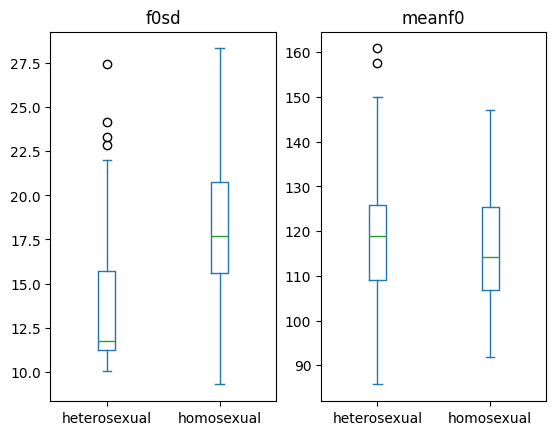

In [7]:
df.plot.box(by="orientation", column=["meanf0", "f0sd"])
plt.show()

Clearly, there isn't much difference regarding the *mean* pitch per speaker category, but the *standard deviation* for the homosexual speakers seems to be much higher. Could this be true? Such a question is a vanilla application for statistical tests, since we'd like to establish that the difference between the mean pitch is (indeed?) **statistically insignificant**, just as we'd like to ascertain that the difference in standard deviation is (indeed?) **significantly different**.

Let us split the dataframe into two groups to make things easier later

In [8]:
hom_df = df[df["orientation"] == "homosexual"]
het_df = df[df["orientation"] == "heterosexual"]

The question whether the values in one group are different (viz. lower/higher) from the values in another group is very common in statistics and a number of tests would be applicable. Many of these, however, come with complex requirements of your data. Many of them will for instance critically assume that the values in both your groups are normally distributed. If you create a density plot, however, for the two groups of "f0sd", you can see that these values don't behave very "normally":

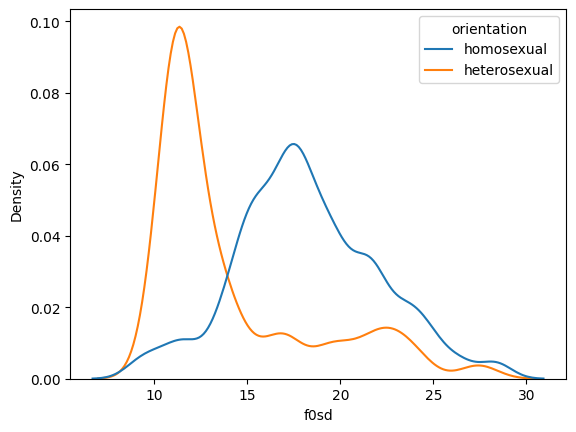

In [9]:
# Reducing the 'bandwidth' for the density estimation fits closer to the data, increasing it gives
# us smoother curves.
sns.kdeplot(df, x="f0sd", hue="orientation", bw_adjust=0.5)

plt.show()

Like before, let's eyeball the normality using QQ plots.

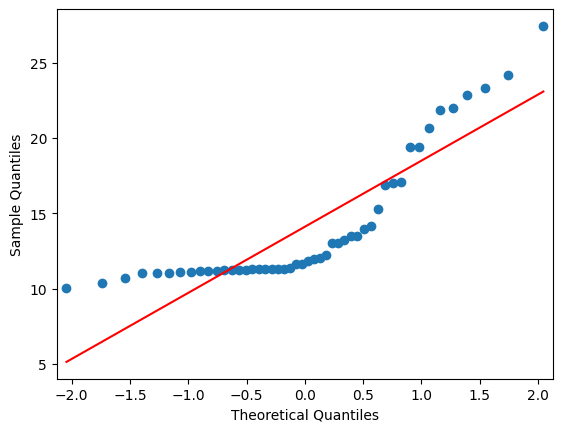

In [10]:
sm.qqplot(het_df["f0sd"], line="s")
plt.show()

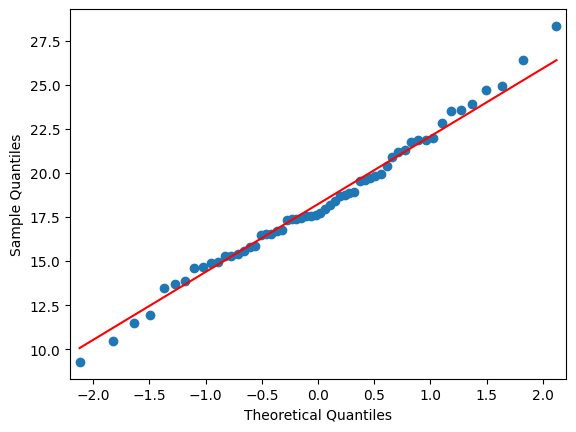

In [11]:
sm.qqplot(hom_df["f0sd"], line="s")
plt.show()

For the homosexual men, the distribution seems "kinda" Gaussian, but that's not the case for the heterosexual group. (That makes sense also, the since the variance for heterosexual group is much smaller. Think about that!) The problem is that this situation prevents us from running a whole bunch of tests that require each group to be normally distributed. Such tests, which come with many requirements about the shape of your data, are called **parametric tests**.

The Wilcoxon rank-sums test, however, is a **non-parametric test**: these tests are interesting because they come with  very few, if any, requirements and are very broadly applicable. These tests are used in very many contexts, for instance, to answer one of the classic questions in corpus linguistics, i.e. whether the frequency of a word is different in two corpora. For many reasons, the Wilcoxon rank-sums test is a test you'll learn to love, because it is: 
  - widely applicable
  - free of assumptions
  - insensitive to outliers
  - conceptually simple
  
In this next section, we'll talk you through the calculation of the test statistic -- as the name suggests, this will involve some summing of ranks. We'll start, however, by just running the test in its standard implementation in Python:

#### Running your first statistical test:

Let's recap again, because this is important. This version of Wilcoxon (or Mann-Whitney U) assess the null hypothesis that two distributions are the same. For a two-sided test, $H_0$ is "these samples come from the same distribution" and $H_1$ is "they come from different distributions". As always, a $p$-value below the critical threshold is ground to **reject $H_0$**

> In Scipy, this test is called the Mann-Whitney U test, which is the same as the Wilcoxon rank-sum test. **Be careful**, because `sp.stats.wilcoxon` does exist, but performs a different test, called the Wilcoxon signed-rank test. However, if you ever use R, the test you want *is* called `wilcoxon`. Yes, it is all very confusing.

We run the test twice: once to determine whether the difference in "meanf0" is different across the groups, and once for the difference in "f0sd". The only additional thing which we specify is that we want to carry out a "two-sided" test, indicating that our hypothesis is non-directional (i.e. we care about the effect, but not about its direction). Note that for "f0sd" we could in principle have opted for one-sided test, since we have the clear expectation that the "f0sd" would be *larger* in the heterosexual group.

In [12]:
sp.stats.mannwhitneyu(hom_df.f0sd, het_df.f0sd, alternative="two-sided")

MannwhitneyuResult(statistic=2178.5, pvalue=6.07579490494034e-07)

In [13]:
sp.stats.mannwhitneyu(hom_df.meanf0, het_df.meanf0, alternative="two-sided")

MannwhitneyuResult(statistic=1288.5, pvalue=0.5132818705771971)

For the one-sided test, our base group is `hom.f0sd`, $H_0$ is "the base group does not have greater variance in F0" and the alternative $H_1$ is "the base group values are stochastically *greater*".

In [14]:
sp.stats.mannwhitneyu(hom_df.f0sd, het_df.f0sd, alternative="greater")

MannwhitneyuResult(statistic=2178.5, pvalue=3.03789745247017e-07)

As with most statistical tests, two things are being returned by the test: a test statistic ($U$) and the associated $p$-value. As you already know, the test statistic captures how large the difference is (i.e. the so-called **effect size**) and the $p$-value tells us how surprised we should be by the size of that difference. Assuming that we adopt the conventional critical threshold of 0.05, we can see that:
 - in the case of the mean F0, the test gives us a p-value that is much higher than that threshold, meaning that we can *not* reject the null hypothesis in this case; 
 - the case of the variance of F0 yields a very tiny $p$-value ($p$ <<< 0.05) meaning that we should reject the null hypothesis in this case.
 
That all sounds great: but how was $U$ calculated?

#### Looking at ranks, instead of values

The test statistic that we need to calculate for this test is $W$ (or sometimes called $U$, given the alternative name Mann-Whitney $U$ of the test). As you know, the test statistic is meant to somehow capture the size of the difference between the two groups. When we would start calculating the numeric difference between the actual values in both groups, we run into the risk of hitting outliers: if one of the values in the groups would be very extreme, that would mess up the entire test statistic. Our Wilcoxon rank sums bypasses this danger by focusing on ranks, instead of the actual values.

It does this in a very specific way. We take our full data frame, select the relevant column and simply rank the values (it doesn't matter whether we do this in ascending or descending order, but the formal specification of the test states 'ascending'):

In [15]:
df["rank_sd"] = df.f0sd.rank(ascending=True)
df["rank_mean"] = df.meanf0.rank(ascending=True)
df.sort_values(by="rank_sd")

,orientation,meanf0,f0sd,rank_sd,rank_mean
132,homosexual,101.60,9.28,1.0,15.0
21,heterosexual,118.30,10.06,2.0,57.0
26,heterosexual,123.72,10.40,3.0,76.0
88,homosexual,91.78,10.44,4.0,4.0
79,heterosexual,138.26,10.71,5.0,95.0
...,...,...,...,...,...
119,homosexual,109.24,24.71,102.0,34.0
114,homosexual,107.53,24.95,103.0,27.0
140,homosexual,113.35,26.37,104.0,46.0
156,heterosexual,123.59,27.43,105.0,75.0


We created two new vectors: for each of the two columns of interest, we have recorded which overall rank that value would have, if we ordered all the values in that column. Let us plot a boxplot of those ranks now (and forget about the actual values):

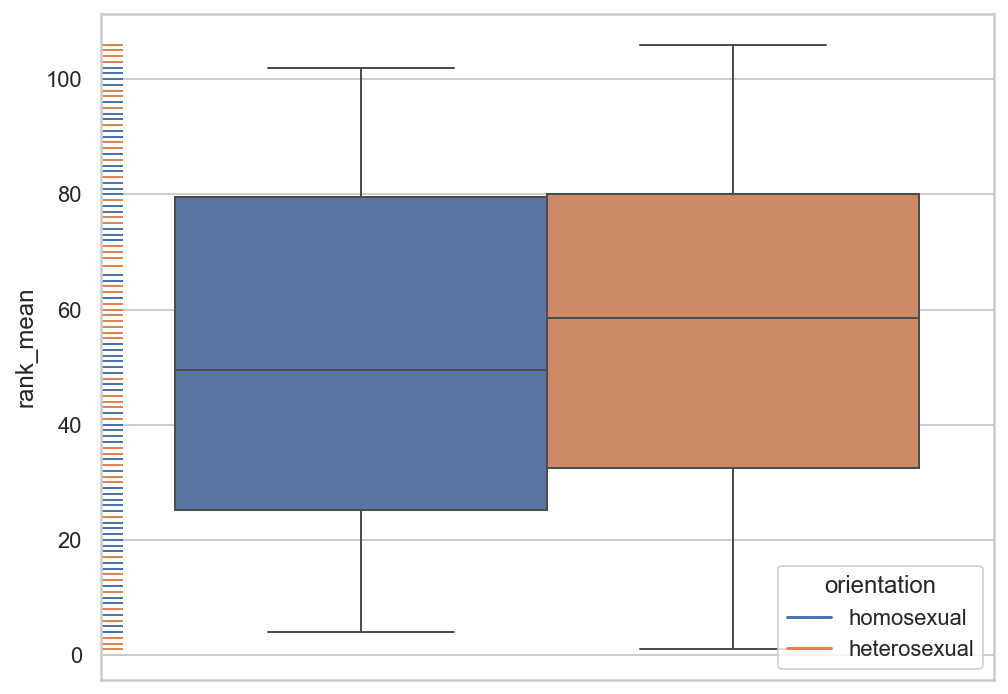

In [16]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    rc={"figure.figsize": (8, 6), "figure.dpi": 144},
)

ax = sns.boxplot(df, y="rank_mean", hue="orientation")
sns.rugplot(df, y="rank_mean", hue="orientation")
sns.move_legend(ax, "lower right")

plt.show()

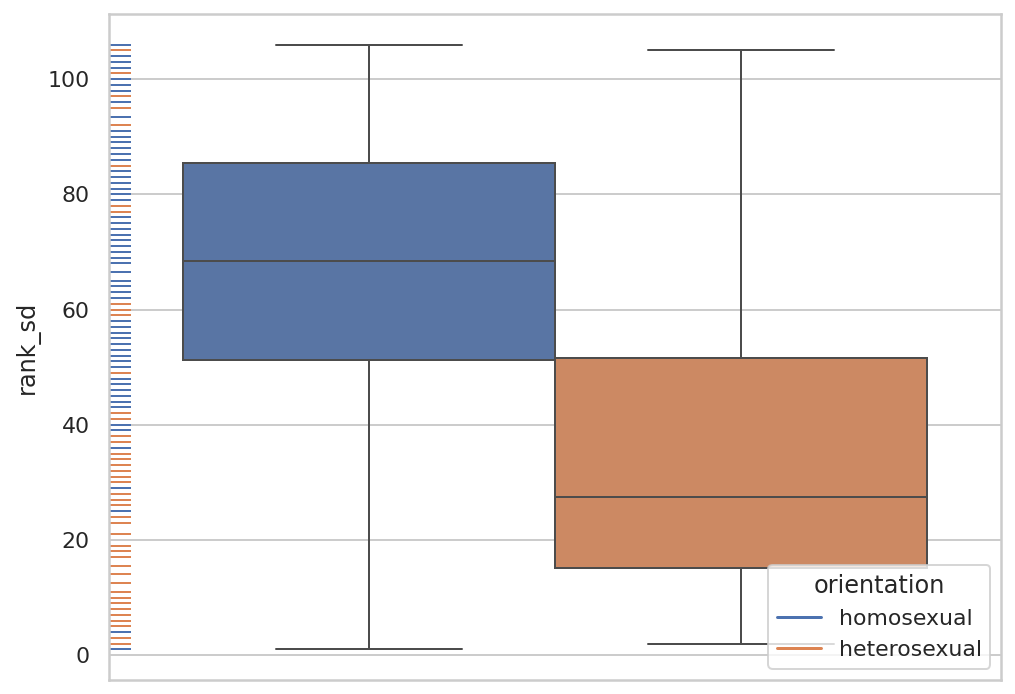

In [17]:
ax = sns.boxplot(df, y="rank_sd", hue="orientation")
sns.rugplot(df, y="rank_sd", hue="orientation")
sns.move_legend(ax, "lower right")

sns.reset_defaults()
plt.show()

First of all, it's clear that the difference in medians for both categories is relatively larger in the second case (for "f0sd"). As a reading aid, we've also added small ticks (using `rugplot()`) on the vertical axis line to indicate where the ranks are located for each group; using different colors. If you look closely, you'll notice that in the first graph, there is no real difference across colors, whereas in the second plot, you'll notice that the blue stripes cluster towards the lower end.

Our test statistic $U$ is wholly calculated on the basis of the ranks of our values, instead of the actual values. By using ranks, we have the garantee that outliers won't affect our calculation much: even if a value is really high, it would just be ranked last, but that rank itself wouldn't be a very extreme value. In fact, many other non-parametric tests, such as Kendall's $\tau$ also look at ranks, instead of actual values, and this is precisely what makes them non-parametric.

#### Calculating $U$

Our test statistic $U$ is calculated by comparing the ranks in our two groups. The intuition is as follows: if there is no real difference in values across our two groups, their ranks should be **well shuffled**; in that case, we would expect that the values of one group wouldn't be ranked consistently higher than the values of the other. Let us start with the "f0sd" column: let us sort the rows of the data frame by the value of f0sd:

The "rank" column is added to make explicit which rank each rows was assigned. We can now split out these ranks across two categories:

In [18]:
ranks_hom = df.rank_sd[df.orientation == "homosexual"]
ranks_het = df.rank_sd[df.orientation == "heterosexual"]

We now want to compare the ranks in these groups: if there wouldn't be a difference across these two groups, the values for one of the groups shouldn't consistently outrank those from the other group. To calculate $W$, we therefore compare each rank from the first group ($x_i$), with every rank in the second group ($y_i$) and check whether the first rank is smaller than the second rank. $W$ then is the number of times where $x_i < y_i$. We can calculate this as follows with an explicit for-loop:

> CODING ALERT
>
> In general, if you find yourself iterating over pandas `Series` objects like this something has gone wrong and there is typically a better way. For this particular example, we absolve you of sin.

In [19]:
U = 0
for i, hom in ranks_hom.items():
    for j, het in ranks_het.items():
        if het == hom:
            # equal rank
            U += 0.5
        elif het < hom:
            U += 1
        else:
            # do nothing
            U = U
U

2178.5

You will recognize this value for $U$, since it's the test statistic being returned by the `mannwhitneyu()` above. As promised, the number gives us a sense of the overall difference between the two groups: it counts how often a rank from the first group is lower than a rank from the second group, if we exhaustively compare all ranks from the two groups.

The question now becomes how surprised we should be with this particular $U$? Is the value of 2178.5 large or pretty average? What would be the outcome that we would expect, if there were no difference whatsoever between the groups? Or put differently, even if we allow for some "wiggle" in the results, what would be the distribution of the test statistic $U$? In this case, we can guess pretty well what the expected mean $\mu$ of this distribution would be, if there were no difference:

In [20]:
n1 = len(ranks_hom)
n2 = len(ranks_het)

mu = (n1 * n2) / 2
mu

1392.0

We can calculate the number of possible pairs of ranks (each time involving one from each group). If there would be no difference in ranks, the ranks would be "shuffled" we could anticipate that in roughly half of the cases a rank from group one would be lower than a rank from group 2. That's why the mean of the expected distribution for $W$ is equal to $(n1 \cdot n2) / 2$. You see how this test is cleverly defined: we calculate a test statistic of which we know what the distribution should look like, if the null hypothesis were true.

How we can predict the expected mean $\mu$ for $W$ is intuitive, but the analogous reasoning for the standard deviation $\sigma$ is harder to understand so I'll just give you the formula for that:

In [21]:
sigma = math.sqrt((n1 * n2) * (n1 + n2 + 1) / 12)
sigma

157.55633912984905

We now have the two crucial ingredients to plot our expected distribution and re-assess our actual test statistic in the light of this. First, let's get an intuitive feel for the distribution with bootstrap statistics:

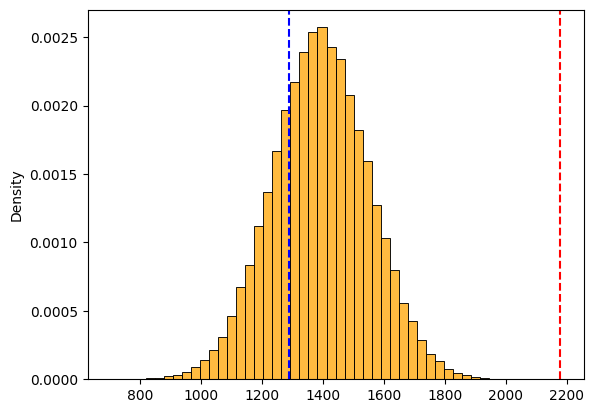

In [22]:
# bootstrap normal sample
rng = np.random.default_rng(seed=42)
numbers = rng.normal(loc=mu, scale=sigma, size=100000)

ax = sns.histplot(
    x=numbers,
    color="orange",
    stat="density",
    bins=50,
)
# plot the U statistics for f0sd (red) and meanf0 (blue)
ax.axvline(2178.5, color="red", linestyle="--")
ax.axvline(1288.5, color="blue", linestyle="--")

plt.show()

In [23]:
# Some people call this a "bootstrap p-value"
1 - (sp.stats.percentileofscore(numbers, 2178.5, kind="weak") / 100)

1.0000000000065512e-05

As you can see, the test statistic value that we obtained is unlike anything we would have expected, assuming that there was no difference in ranks. This immediately explains the extremely low $p$-value that was returned by `wilcox.test()` above.


The distribution for $U$ is not a standard normal, but for large samples it is well approximated by the normal distribution. To see this, we can calculate a theoretical $p$-value like we did before, using the normal CDF for these empirical $\mu$ and $\sigma$ values:

In [24]:
dist = sp.stats.norm(loc=mu, scale=sigma)
1 - dist.cdf(2178.5)

2.9899499054408807e-07

... and we see it is extremely close to the scipy $p$-value! Success!

In [25]:
sp.stats.mannwhitneyu(hom_df.f0sd, het_df.f0sd, alternative="greater")

MannwhitneyuResult(statistic=2178.5, pvalue=3.03789745247017e-07)

##### Exercise
> Repeat the manual calculation of the test statistic above for "meanf0" and redo the plot from the previous code block: can you reproduce the $U$ statistic that is produced by `mannwhitneyu()`?

In [26]:
sp.stats.mannwhitneyu(hom_df.meanf0, het_df.meanf0, alternative="two-sided")

MannwhitneyuResult(statistic=1288.5, pvalue=0.5132818705771971)

In [27]:
# code here

##### Rank sums?

This isn't crucial but you might wonder why this test is known as a "rank sums" test? How was there summing of ranks involved? That has to do with the fact that there's a smarter method to calculate $W$, instead of using an analytical for-loop, as we did above, which *does* involve summing the ranks.

In [28]:
ranks_hom.sum() - (ranks_hom.size * (ranks_hom.size + 1) / 2)

2178.5

That's all.

## Take-home message

We won't have time to cover each statistical test in the same level of detail, but we wanted to give you an intuition as to how these tests are cleverly constructed. When we calculate a given test statistic, we can formalize what its value should look like if the null hypothesis were true. Because you known in advance what the distribution of the test statistic should look like, you can calculate how surprising the actual test statistic is that you obtain. Using the combination of a $p$-value and a critical threshold (that you should set in advance, to avoid "cheating"), you can make explicit why and at which point you reject the null hypothesis $H_0$ in favour of the alternative hypothesis $H_1$. While all tests that we'll cover in the next sprint have a different underlying narrative and rationale, they all share the basic hypothesis testing principle.

<img src=https://imgs.xkcd.com/comics/null_hypothesis.png />

(from [xkcd](https://xkcd.com/892/))

```
Version History

Current: v1.0.1

23/9/24: 1.0.0: first draft, BN
04/10/24: 1.0.1: typos + proofreading, MK
```